# 2. TensorFlow Datasets (TFDS)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

imdb_data = tfds.load(name="imdb_reviews", split="train")
imdb_df = tfds.as_dataframe(imdb_data)
print(f"Shape of data: {imdb_df.shape}")

Shape of data: (25000, 2)


# 3. Exploring the IMDB Dataset

In [2]:
imdb_df['text'] = imdb_df['text'].str.decode('utf-8')
imdb_sample = imdb_df.sample(frac=0.2, random_state=100)

In [3]:
print(f'Shape of sample: {imdb_sample.shape}')

Shape of sample: (5000, 2)


In [4]:
imdb_sample.head(10)

,label,text
20094,1,"""The Godfather"" of television, but aside from ..."
17218,0,"Okay, I've watched this movie twice now, I hav..."
3773,0,"Okay, so the previews to this film only tells ..."
20529,0,Yet ANOTHER movie about a group of less-than-i...
18073,1,This unpretentious Horror film is probably des...
15045,1,"updated January 1st, 2006<br /><br />Parsifal ..."
17053,0,"Although this isn't a ""great film,"" there's so..."
23397,1,Cameron Grant is one of the best directors doi...
10531,0,I do not watch much television and came across...
24690,1,As the first of the TV specials offered on the...


In [5]:
imdb_sample.tail(10)

,label,text
15026,1,"""THINGS TO COME"" Movie Review by kWRice<br /><..."
7998,0,Slaughter High the tale of revenge by a nerdy ...
4055,0,"As a lesbian, I am always on the lookout for f..."
23541,0,A movie about dealing with the problems with g...
2214,0,"Yes, people are racist. People are even racist..."
14369,1,My introduction into Yoji Yamada's cinematic w...
12598,0,"True, there are many movies much worse then th..."
23487,1,I hadn't laughed this hard for a movie in a re...
18067,1,To call this episode brilliant feels like too ...
8253,0,All of the X-Men movies were great. And I mean...


In [6]:
imdb_sample['label'].value_counts()

1    2537
0    2463
Name: label, dtype: int64

In [7]:
imdb_sample.isna().sum()

label    0
text     0
dtype: int64

# 4. Word Distribution

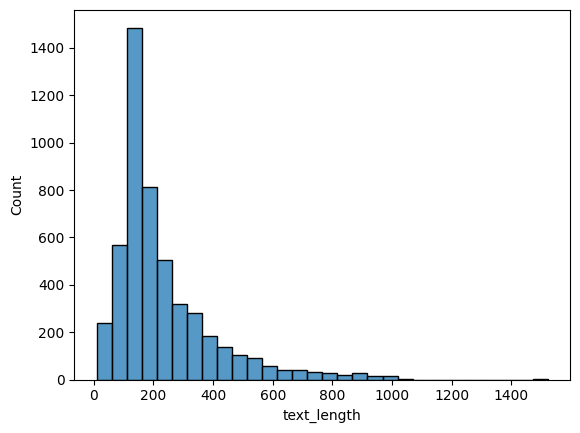

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

imdb_sample['text_length'] = [len(review.split(' ')) for review in imdb_sample['text']]
sns.histplot(data=imdb_sample, x='text_length', bins=30)
plt.show()

In [9]:
imdb_sample.groupby(by="label")[["text_length"]].mean()

,text_length
label,
0,229.644336
1,232.267639


In [10]:
imdb_sample.groupby(by="label")[["text_length"]].median()

,text_length
label,
0,170.0
1,174.0


In [11]:
imdb_sample.groupby(by="label")[["text_length"]].std()

,text_length
label,
0,168.513263
1,170.442863


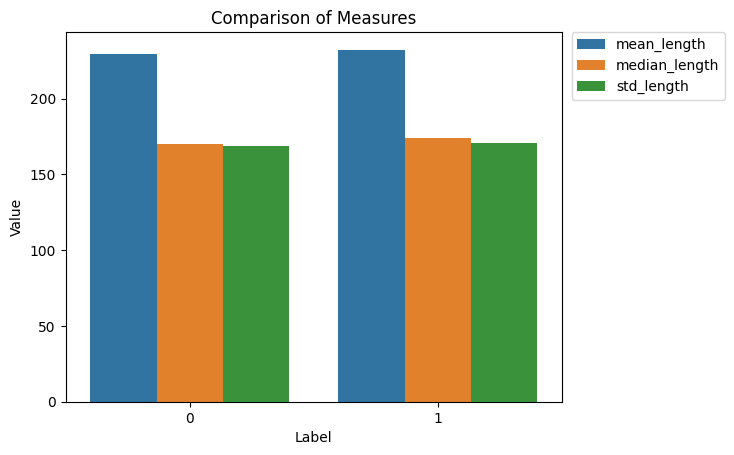

In [12]:
# Optional bar plot code
mean_length = imdb_sample.groupby(by="label")[["text_length"]].mean().reset_index()
median_length = imdb_sample.groupby(by="label")[["text_length"]].median().reset_index()
std_length = imdb_sample.groupby(by="label")[["text_length"]].std().reset_index()

combined_df = pd.concat([mean_length, median_length["text_length"], std_length["text_length"]], axis=1)
combined_df.columns = ["label", "mean_length", "median_length", "std_length"]
melted_df = pd.melt(combined_df, id_vars="label", var_name="Measure", value_name="Value")

sns.barplot(data=melted_df, x="label", y="Value", hue="Measure")
plt.xlabel("Label")
plt.ylabel("Value")
plt.title("Comparison of Measures")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.show()


Based on the results above, there doesn't appear to be a correlation between `text_length` and `label`.

# 5. Visualizing the Most Frequent Words

In [13]:
freq_words = imdb_sample['text'].str.split(expand=True).stack().value_counts()
freq_words_top100 = freq_words[:100]
freq_words_top100.describe()

count      100.000000
mean      5268.970000
std       7879.556446
min       1243.000000
25%       1669.750000
50%       2291.000000
75%       5076.000000
max      56231.000000
dtype: float64

In [14]:
import plotly.express as px

fig = px.treemap(freq_words_top100, path=[freq_words_top100.index], values=0)
fig.update_layout(title_text='Most Frequent 100 Words in the Dataset', title_font=dict(size=20))
fig.show()

# 6. Text Preprocessing

In [15]:
imdb_sample['text'] = imdb_sample['text'].str.lower()

import re

def punctuation(inputs):
    return re.sub(r'[^\w\s]', ' ', inputs)

imdb_sample['text'] = imdb_sample['text'].apply(punctuation)

imdb_sample.head()

,label,text,text_length
20094,1,the godfather of television but aside from ...,243
17218,0,okay i ve watched this movie twice now i hav...,639
3773,0,okay so the previews to this film only tells ...,173
20529,0,yet another movie about a group of less than i...,384
18073,1,this unpretentious horror film is probably des...,32


# 7. Text Preprocessing (cont.)

In [16]:
# Tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def tokenization(inputs):
    return word_tokenize(inputs)

imdb_sample['text_tokenized'] = imdb_sample['text'].apply(tokenization)
imdb_sample['text_tokenized'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


20094    [the, godfather, of, television, but, aside, f...
17218    [okay, i, ve, watched, this, movie, twice, now...
3773     [okay, so, the, previews, to, this, film, only...
20529    [yet, another, movie, about, a, group, of, les...
18073    [this, unpretentious, horror, film, is, probab...
Name: text_tokenized, dtype: object

In [17]:
# Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.add('br')

def stopwords_remove(inputs):
    return [word for word in inputs if word not in stop_words]

imdb_sample['text_stop'] = imdb_sample['text_tokenized'].apply(stopwords_remove)
imdb_sample['text_stop'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


20094    [godfather, television, aside, acclaim, mobste...
17218    [okay, watched, movie, twice, researched, heav...
3773     [okay, previews, film, tells, rebellious, youn...
20529    [yet, another, movie, group, less, intelligent...
18073    [unpretentious, horror, film, probably, destin...
Name: text_stop, dtype: object

In [18]:
# Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=word, pos='v') for word in inputs]

imdb_sample['text_lemmatized'] = imdb_sample['text_stop'].apply(lemmatization)
imdb_sample['text_lemmatized'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


20094    [godfather, television, aside, acclaim, mobste...
17218    [okay, watch, movie, twice, research, heavily,...
3773     [okay, preview, film, tell, rebellious, young,...
20529    [yet, another, movie, group, less, intelligent...
18073    [unpretentious, horror, film, probably, destin...
Name: text_lemmatized, dtype: object

# 8. Visualization of Reviews after Text Preprocessing

In [19]:
imdb_sample['final'] = imdb_sample['text_lemmatized'].str.join(' ')

freq_words = imdb_sample['final'].str.split(expand=True).stack().value_counts()
freq_words_top100 = freq_words[:100]

fig = px.treemap(freq_words_top100, path=[freq_words_top100.index], values=0)
fig.update_layout(title_text='Most Frequently Used 100 Words after Text Preprocessing', title_font=dict(size=20))
fig.show()

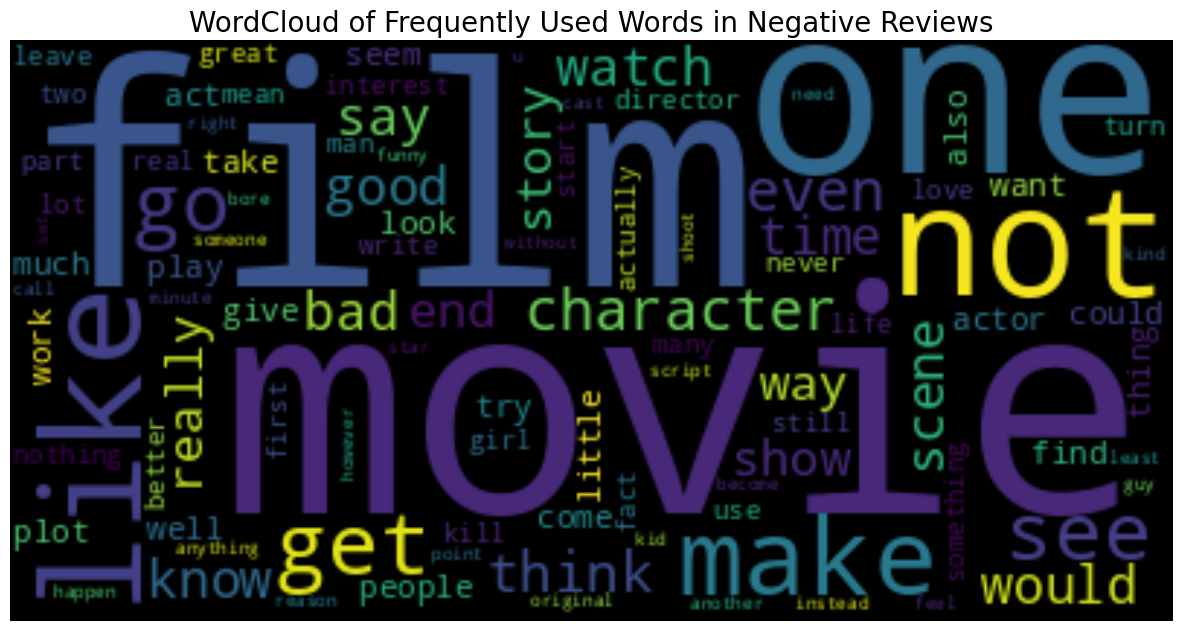

In [20]:
from wordcloud import WordCloud

# Negative movie reviews
imdb_sample_0 = imdb_sample[imdb_sample['label'] == 0]
word_cloud_0 = WordCloud(max_words=100, stopwords=stop_words, random_state=100).generate(' '.join(imdb_sample_0['final'].tolist()))

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Negative Reviews', fontsize=20)
plt.axis("off")
plt.show()

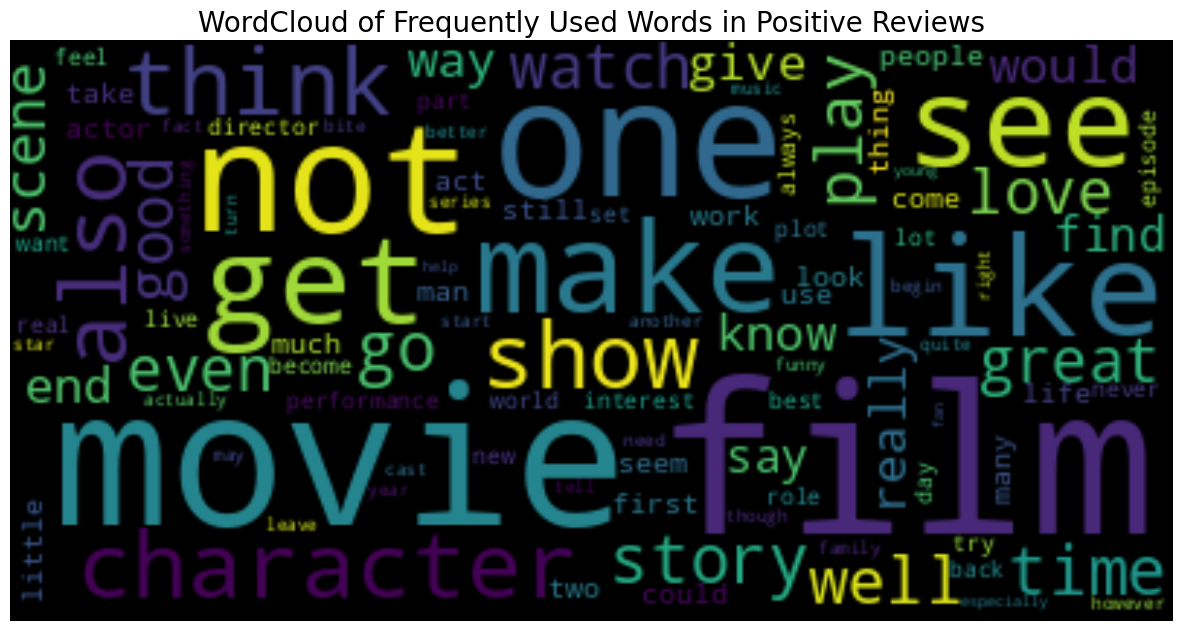

In [21]:
# Positive movie reviews
imdb_sample_1 = imdb_sample[imdb_sample['label'] == 1]
word_cloud_1 = WordCloud(max_words=100, stopwords=stop_words, random_state=100).generate(' '.join(imdb_sample_1['final'].tolist()))

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Positive Reviews', fontsize=20)
plt.axis("off")
plt.show()

The positive and negative word clouds are surprisingly similar but both seem to be in accordance with the `treemap` built on this screen.